# Load Datasets


In [1]:
import sys
import numpy as np
import scipy as sp
import netCDF4 as nc4
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pandas as pd
#from glob import glob
import glob

import numpy.linalg as linalg
import scipy.signal as signal
import scipy.ndimage as ndimage
import scipy.interpolate as interpolate

from netCDF4 import Dataset

from itertools import repeat

# import sys
# sys.path.insert(0, '/home/tsmith/scratch/eddyTracking/ecjoliver/')
# import params 

import re

from scipy.io.netcdf import netcdf_file as netcdf
import cmocean.cm as cmo
import warnings
import matplotlib.colors as colors
from cartopy import crs as ccrs, feature as cfeature

In [2]:
%matplotlib inline

In [3]:
def find_ind(grid1d, coord):
        a=abs(grid1d-coord)
        return np.where(a==np.min(a))[0][0]

## Import RV

In [4]:
%%time
RV_grid = xr.open_mfdataset('../BIOPERIANT12-CNCLNG01_y2005m09d17_RV_OW.nc', decode_times=False)
#, concat_dim='time_counter',combine='nested')

CPU times: user 73.6 ms, sys: 24.2 ms, total: 97.8 ms
Wall time: 138 ms


In [5]:
RV = RV_grid['Relative_Vorticity']
OW = RV_grid['Okubo_weiss_mask']
lons_RV = RV_grid['lons']
lats_RV = RV_grid['lats']

## Import Fronts

In [8]:
#GET FRONTS
fronts = xr.open_mfdataset('../BIOPERIANT12-CNCLNG01_Fronts.nc', decode_times=False)

#already -180 to 180
fronts_lon = fronts['lon']

#annual mean
stf = fronts['stf'].mean('time_counter')
saf = fronts['saf'].mean('time_counter')
pf = fronts['pf'].mean('time_counter')
ice = fronts['iceedge'].mean('time_counter')

In [9]:
#monthly mean
STF_all = fronts['stf']
SAF_all = fronts['saf']
PF_all = fronts['pf']
ICE_all = fronts['iceedge']

In [10]:
k1 = find_ind(fronts_lon,-11)
k2 = find_ind(fronts_lon,15)

In [11]:
i1 = find_ind(lats_RV[:,0],-60)
i2 = find_ind(lats_RV[:,0],-37)

j1 = find_ind(lons_RV[0,:],-11)
j2 = find_ind(lons_RV[0,:],15)


In [12]:
idxF = find_ind(fronts_lon,5)

In [13]:
def plot_box(lon1, lon2, lat1, lat2, boxcolor, boxname, txtcolor):
    plt.plot([lon1, lon1], [lat1, lat2], boxcolor,transform=ccrs.PlateCarree(),linewidth=3,linestyle="--")
    plt.plot([lon2, lon2], [lat1, lat2], boxcolor,transform=ccrs.PlateCarree(),linewidth=3,linestyle="--")
    plt.plot([lon1, lon2], [lat1, lat1], boxcolor,transform=ccrs.PlateCarree(),linewidth=3,linestyle="--")
    plt.plot([lon1, lon2], [lat2, lat2], boxcolor,transform=ccrs.PlateCarree(),linewidth=3,linestyle="--")
    plt.text(lon1+2, lat1+2,boxname,color=txtcolor,fontsize=18,transform=ccrs.PlateCarree())
    return

## Import Temp and DIC climatology 2000-2009

In [14]:
clim_grid = xr.open_mfdataset('../Temp_DIC_climatology_2000_2009.nc', decode_times = False)


In [15]:
clim_Temp = clim_grid['Temperature_Climatology']
clim_DIC = clim_grid['DIC_Climatology']

In [16]:
depth = clim_grid['deptht']

In [17]:
lons = clim_grid['lons']
lats = clim_grid['lats']

## Time

In [18]:
time_val = RV_grid['time_counter']

In [19]:
import datetime
import netCDF4

calendar = 'noleap'
units = 'seconds since 1988-12-31 00:00'



In [20]:
#time_date is cftime
time_date = netCDF4.num2date(time_val, units=units, calendar=calendar)

# time_stamp = []
# for i in time_date:
#     time_stamp.append(pd.Timestamp(i.year,i.month,i.day))

## Main Plot

Text(0.74, 0.46, '(e)')

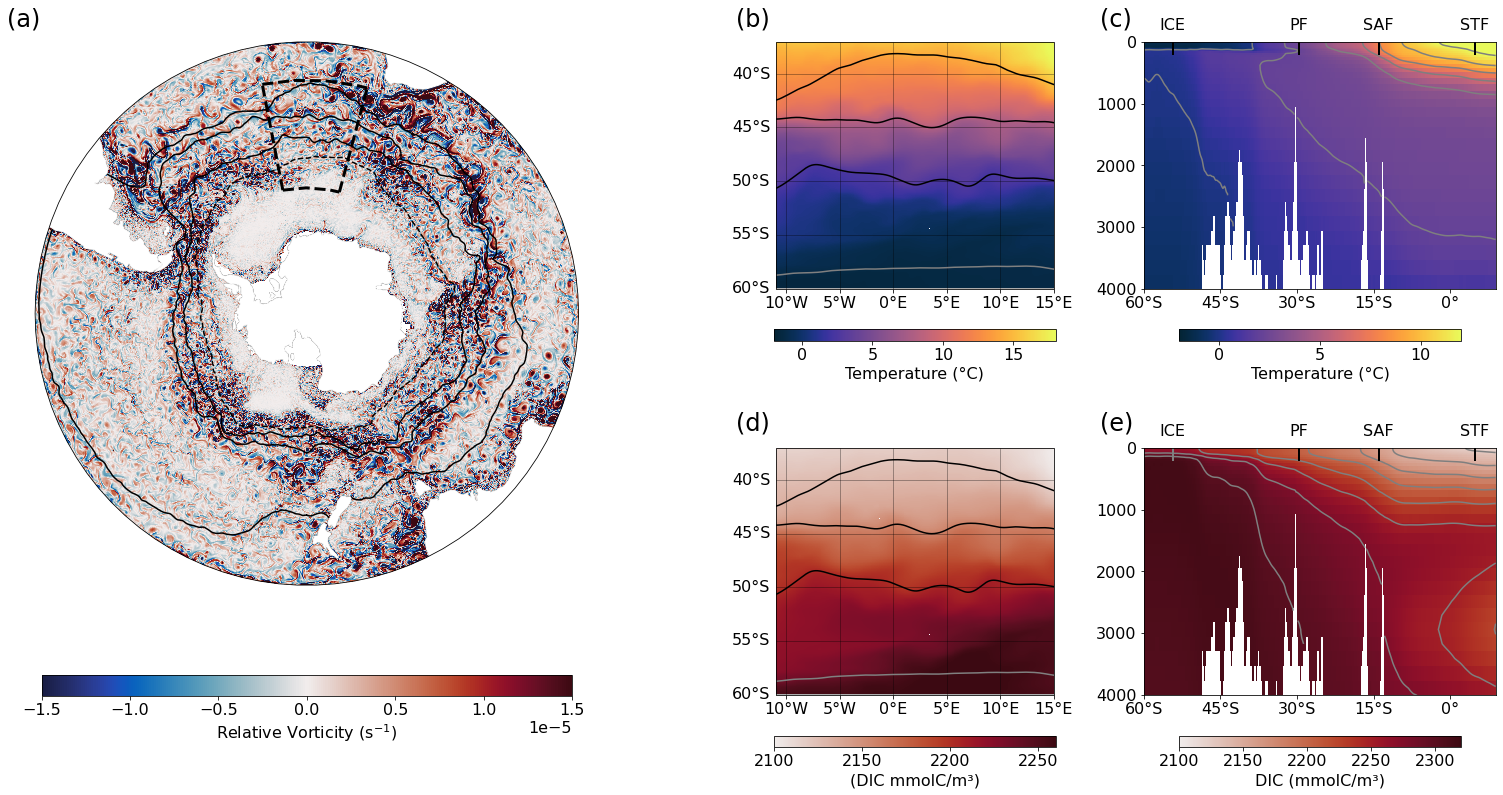

In [21]:
plt.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

#longitude=5°E
lonX = 5
idx0 = find_ind(lons[0,:],lonX )
idxF = find_ind(fronts_lon,lonX)

# Create the figure and gridspec
fig = plt.figure(figsize=(22, 11),facecolor='white')
gs = gridspec.GridSpec(2, 4)

# Define the projections for the subplots
stereo_proj = ccrs.Stereographic(central_latitude=-90, scale_factor=6.75)
platecarree_proj = ccrs.PlateCarree()

# Subplot 1 - Stereographic projection, 2 rows, 2 columns
ax1 = fig.add_subplot(gs[0:2, 0:2], projection=stereo_proj)

# date = pd.Timestamp(2005,9,17)
# t_val = netCDF4.date2num(date, units=units, calendar=calendar)
# idx  = find_ind(time_val,t_val)
month = time_date.month

mesh = ax1.pcolormesh(lons_RV[0,:], lats_RV[:,0], RV, vmin=-1.5e-5,vmax=1.5e-5, 
                     cmap=cmo.balance,shading='nearest',
                     transform=ccrs.PlateCarree(),zorder=-2)
cb = plt.colorbar(mesh, orientation = 'horizontal', shrink=0.7, aspect = 25, pad = 0.12,  label='Relative Vorticity (s$^{-1}$)')
#ptitle = 'BIOPERIANT12 surface EKE '+ str(eke_surf12.time_counter[0].values)[:10]
#plt.title(ptitle,loc='left',fontsize=12)
ax1.coastlines(zorder=1,color='k')
#ax.set_extent(-90, -30)
ax1.add_feature(cfeature.LAND, color='white', zorder=1)
#gl = ax.gridlines(draw_labels=False,color='k',lw=0.1,alpha=0.4) # labels dont work yet with stereograph - eye roll

ax1.plot(fronts_lon, STF_all[month-1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='STF',zorder=-1)
ax1.plot(fronts_lon, SAF_all[month-1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='SAF')
ax1.plot(fronts_lon, PF_all[month-1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='PF')
ax1.plot(fronts_lon, ICE_all[month-1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='ICE')

#ax.plot(fronts_lon, stf2, 'white',linestyle = '-',transform=ccrs.PlateCarree(), label='STF')

plot_box(-11, 15, -60, -37, 'k', '', 'white')

# Customize the subplot ax1 as needed

# Subplot 2 - PlateCarree projection, (0,2)
ax2 = fig.add_subplot(gs[0, 2], projection=platecarree_proj)
mesh = ax2.pcolormesh(lons[0,:], lats[:,0], clim_Temp[0],vmin=-2,vmax=18 ,
                     cmap=cmo.thermal,
                     transform=ccrs.PlateCarree(),zorder=0)
cb1 = plt.colorbar(mesh, ax=ax2,orientation = 'horizontal', shrink=0.8, aspect = 25, pad = 0.12,  label='Temperature (°C)')


#ptitle = 'BIOPERIANT12 surface EKE '+ str(eke_surf12.time_counter[0].values)[:10]
#plt.title(ptitle,loc='left',fontsize=12)
#ax[0].coastlines()
ax2.set_extent([-11, 15,-59.8,-37])
#ax[0].add_feature(cfeature.LAND, color='white', zorder=1)
gl = ax2.gridlines(draw_labels=True,color='k',lw=0.1,alpha=0.4,ylocs=[-60,-55,-50,-45,-40]) # labels dont work yet with stereograph - eye roll
# gl = ax[0].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180], ylocs=[-90, -60, -30, 0, 30, 60, 90],
#                   color='k', linewidth=0.1, alpha=0.4)

gl.top_labels = False  # Disable labels on the top edge
gl.right_labels = False  # Disable labels on the right edge
gl.bottom_labels = False

ax2.set_xticks([-10,-5,0,5,10,15])
ax2.set_xticklabels(['10°W', '5°W', '0°E', '5°E', '10°E','15°E'])


ax2.plot(fronts_lon[k1:k2+1], stf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='STF')
ax2.plot(fronts_lon[k1:k2+1], saf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='SAF')
ax2.plot(fronts_lon[k1:k2+1], pf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='PF')
ax2.plot(fronts_lon[k1:k2+1], ice[k1:k2+1], 'gray',linestyle = '-',transform=ccrs.PlateCarree(), label='ICE')


# Subplot 3 - PlateCarree projection, (0,3)
ax3 = fig.add_subplot(gs[0, 3])
                      #, projection=platecarree_proj)
mesh3 = ax3.pcolormesh(lats[:,0], depth, clim_Temp[:,:,idx0],vmin=-2,vmax=12 ,
                     cmap=cmo.thermal, shading='nearest',
                       #transform=ccrs.PlateCarree(),
                    zorder=0)

ax3.set_ylim(4000,0)
ax3.set_xlim(-60,-37)
ax3.set_xticks([-60,-55,-50,-45,-40])
ax3.set_xticklabels(['60°S', '45°S', '30°S', '15°S', '0°'])

#tick marks for the fronts
surface_y = 0
# surface_x = stf[idx0]
line_length = 500  # Adjust the length of the line as needed
line_width = 2  # Adjust the width of the line as needed
#stf
ax3.axvline(stf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#saf
ax3.axvline(saf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#pf
ax3.axvline(pf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#ice
ax3.axvline(ice[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)

# Add a text label
ax3.text(stf[idxF]-0.025, surface_y - 200, 'STF', ha='center') #xcoord,ycoords,text
ax3.text(saf[idxF]-0.025, surface_y - 200, 'SAF', ha='center')
ax3.text(pf[idxF]-0.025, surface_y - 200, 'PF', ha='center')
ax3.text(ice[idxF]-0.025, surface_y - 200, 'ICE', ha='center')

con3 = ax3.contour(lats[:,0],depth, 
               clim_Temp[:,:,idx0],  
                  levels=[-2,0,2,4,6,8,10,12],
               # levels=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14],
#                         ,levels = [2125,2130,2135, 2140, 2145, 2150, 2155, 2160, 2165, 2170, 2175, 2180, 2185,
#        2190, 2195, 2200, 2205, 2210, 2215, 2220,2225,2230],
             colors='tab:grey')

#ax3.clabel(con3, inline=True, fontsize=10)



cb3 = plt.colorbar(mesh3, orientation = 'horizontal', shrink=0.8, aspect = 25, pad = 0.12,  label='Temperature (°C)')

# Subplot 4 - PlateCarree projection, (1,2)
ax4 = fig.add_subplot(gs[1, 2], projection=platecarree_proj)
mesh = ax4.pcolormesh(lons[0,:], lats[:,0], clim_DIC[0]*1e6,
                      vmin=2100,vmax=2260 ,
                     cmap=cmo.amp,
                     transform=ccrs.PlateCarree(),zorder=0)
#cb1 = plt.colorbar(mesh, ax=ax[0],orientation = 'vertical', shrink=0.7, aspect = 25, pad = 0.12,  label='Temperature °C')


#ptitle = 'BIOPERIANT12 surface EKE '+ str(eke_surf12.time_counter[0].values)[:10]
#plt.title(ptitle,loc='left',fontsize=12)
#ax[0].coastlines()
ax4.set_extent([-11, 15,-59.8,-37])
#ax[0].add_feature(cfeature.LAND, color='white', zorder=1)
g2 = ax4.gridlines(draw_labels=True,color='k',lw=0.1,alpha=0.4,ylocs=[-60,-55,-50,-45,-40]) # labels dont work yet with stereograph - eye roll
# gl = ax[0].gridlines(draw_labels=True, xlocs=[-180, -120, -60, 0, 60, 120, 180], ylocs=[-90, -60, -30, 0, 30, 60, 90],
#                   color='k', linewidth=0.1, alpha=0.4)

g2.top_labels = False  # Disable labels on the top edge
g2.right_labels = False  # Disable labels on the right edge
g2.bottom_labels = False

ax4.set_xticks([-10,-5,0,5,10,15])
ax4.set_xticklabels(['10°W', '5°W', '0°E', '5°E', '10°E','15°E'])

ax4.plot(fronts_lon[k1:k2+1], stf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='STF')
ax4.plot(fronts_lon[k1:k2+1], saf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='SAF')
ax4.plot(fronts_lon[k1:k2+1], pf[k1:k2+1], 'k',linestyle = '-',transform=ccrs.PlateCarree(), label='PF')
ax4.plot(fronts_lon[k1:k2+1], ice[k1:k2+1], 'gray',linestyle = '-',transform=ccrs.PlateCarree(), label='ICE')

cb4 = plt.colorbar(mesh, ax=ax4,orientation = 'horizontal', shrink=0.8, aspect = 25, pad = 0.12,  label='(DIC mmolC/m\u00B3)')



# Subplot 5 - PlateCarree projection, (1,3)
ax5 = fig.add_subplot(gs[1, 3])
mesh5 = ax5.pcolormesh(lats[:,0], depth, clim_DIC[:,:,idx0]*1e6,vmin=2100,vmax=2320 ,
                     cmap=cmo.amp, shading='nearest',
                       #transform=ccrs.PlateCarree(),
                    zorder=0)

ax5.set_ylim(4000,0)
ax5.set_xlim(-60,-37)
ax5.set_xticks([-60,-55,-50,-45,-40])
ax5.set_xticklabels(['60°S', '45°S', '30°S', '15°S', '0°'])

surface_y = 0
# surface_x = stf[idx0]
line_length = 500  # Adjust the length of the line as needed
line_width = 2  # Adjust the width of the line as needed
#stf
ax5.axvline(stf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#saf
ax5.axvline(saf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#pf
ax5.axvline(pf[idxF], ymin=0.95, ymax=1, color='black', linewidth=line_width)
#ice
ax5.axvline(ice[idxF], ymin=0.95, ymax=1, color='grey', linewidth=line_width)

# Add a text label
ax5.text(stf[idxF]-0.025, surface_y - 200, 'STF', ha='center') #xcoord,ycoords,text
ax5.text(saf[idxF]-0.025, surface_y - 200, 'SAF', ha='center')
ax5.text(pf[idxF]-0.025, surface_y - 200, 'PF', ha='center')
ax5.text(ice[idxF]-0.025, surface_y - 200, 'ICE', ha='center')

# ax3.set_ylim(4000, 0)
# ax3.set_yticks([-60, -45, -30, -15, 0])  # Set y-axis tick positions
# ax3.set_yticklabels(['60°S', '45°S', '30°S', '15°S', '0°'])  # Set y-axis tick labels with degree symbols

con5 = ax5.contour(lats[:,0],depth, 
               clim_DIC[:,:,idx0]*1e6,  
                #  levels=[-2,0,2,4,6,8,10,12],
         levels = [2100,2125,2150,2175,2200,2225, 2250, 2275,2300,2325,2350],
#        2190, 2195, 2200, 2205, 2210, 2215, 2220,2225,2230],
             colors='tab:grey')

#ax5.clabel(con5, inline=True, fontsize=10)

cb5 = plt.colorbar(mesh5, orientation = 'horizontal', shrink=0.8, aspect = 25, pad = 0.12,  label='DIC (mmolC/m\u00B3)')

# Add data, titles, and other plot elements to each subplot as desired

# Adjust spacing between subplots if needed
plt.subplots_adjust(wspace=0.15, hspace=0.2)

plt.subplots_adjust(left=0)
plt.subplots_adjust(right=0.99)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.01)

# Add labels
fig.text(0.05, 0.97, '(a)', fontsize=24, fontweight='normal')
fig.text(0.51, 0.97, '(b)', fontsize=24, fontweight='normal')
fig.text(0.74,0.97 ,'(c)', fontsize=24, fontweight='normal')
fig.text(0.51,0.46, '(d)', fontsize=24, fontweight='normal')
fig.text(0.74,0.46, '(e)', fontsize=24, fontweight='normal')

#fig.canvas.draw()
#plt.tight_layout()

# # Display the figure
# plt.show()

#plt.savefig('/home/tsmith/scratch/images/Paper1/Domain_Figure1_NEW.png', dpi=500)


## Supplementary

### Figure S1: Relative Vorticity and Okubo mask domain

In [22]:
import matplotlib.ticker as mticker

In [23]:
from matplotlib.ticker import ScalarFormatter

In [26]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [24]:
OW_nan = OW.where(OW != 0, np.nan)

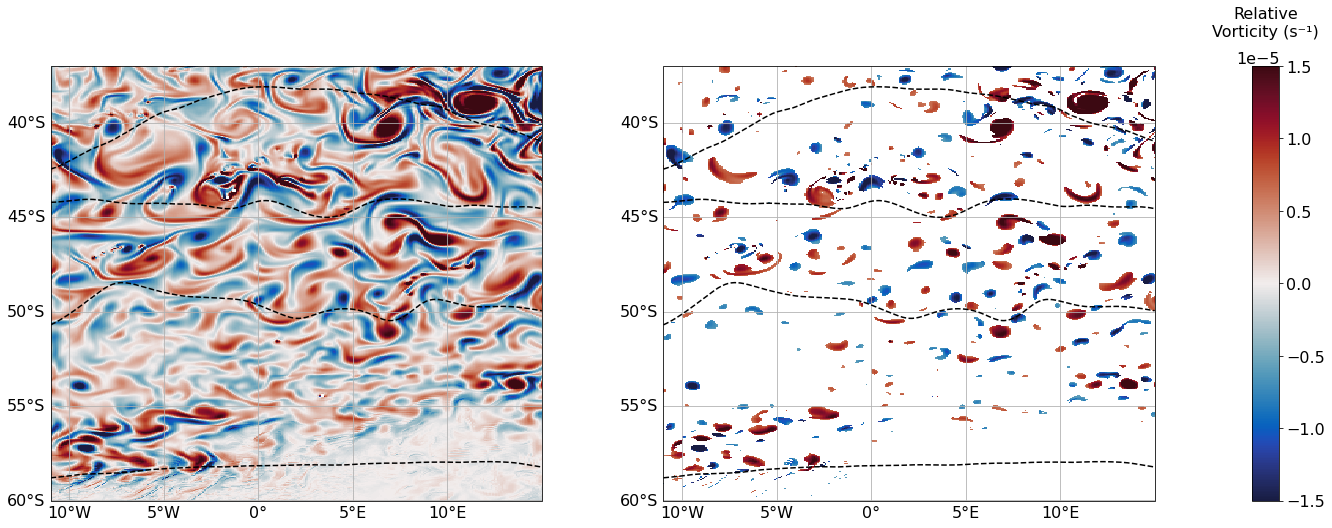

In [30]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(20, 8),facecolor='w')
outer_grid = GridSpec(1, 3, width_ratios=[1, 1, 0.05])

# First grid
i = 0

ax = fig.add_subplot(outer_grid[0],projection=ccrs.PlateCarree(central_longitude=0))

mesh = ax.pcolormesh(lons_RV[0,j1:j2+1], lats_RV[i1-1:i2+1,0], RV[i1-1:i2+1,j1:j2+1],
                     #norm=colors.LogNorm(vmin=-1e-5, vmax=250), 
                     #vmin=0,vmax=1,
                     vmin=-1.5e-5,vmax=1.5e-5 ,
                     shading='auto',
                     zorder = -1, cmap= cmo.balance, transform=ccrs.PlateCarree(central_longitude=0))

#ax.plot(eddy_lon, eddy_lat,'w^')
#plot_box(lon[253], lon[277], lat[378], lat[403], 'green', 'Big eddy', 'k')

# ax.plot(lon_eddies_c[t], lat_eddies_c[t], 'wv')

ax.set_extent([-11, 15, -60.02, -37], ccrs.PlateCarree(central_longitude=0))
gl = ax.gridlines(draw_labels=True)

x_locs = [-10, -5, 0, 5, 10]
y_locs = [-60, -55, -50, -45, -40]

gl.xlocator = mticker.FixedLocator(x_locs)
gl.ylocator = mticker.FixedLocator(y_locs)

# Show only the gridlines on the bottom and left sides
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.top_labels = False

ax.coastlines()

#plot fronts
ax.plot(fronts_lon[k1:k2+1], stf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='STF')
ax.plot(fronts_lon[k1:k2+1], saf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='SAF')
ax.plot(fronts_lon[k1:k2+1], pf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='PF')
ax.plot(fronts_lon[k1:k2+1], ice[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='ICE')


fig.add_subplot(ax)

# Second grid
i = 1

ax = fig.add_subplot(outer_grid[1],projection=ccrs.PlateCarree(central_longitude=0))

mesh = ax.pcolormesh(lons_RV[0,j1:j2+1], lats_RV[i1-1:i2+1,0], OW_nan[i1-1:i2+1,j1:j2+1]* RV[i1-1:i2+1,j1:j2+1],
                     #norm=colors.LogNorm(vmin=-1e-5, vmax=250), 
                     #vmin=0,vmax=1,
                     vmin=-1.5e-5,vmax=1.5e-5 ,
                     shading='auto',
                     zorder = -1, cmap= cmo.balance, transform=ccrs.PlateCarree(central_longitude=0))

ax.set_extent([-11, 15, -60.02, -37], ccrs.PlateCarree(central_longitude=0))
gl = ax.gridlines(draw_labels=True)

x_locs = [-10, -5, 0, 5, 10]
y_locs = [-60, -55, -50, -45, -40]

gl.xlocator = mticker.FixedLocator(x_locs)
gl.ylocator = mticker.FixedLocator(y_locs)

# Show only the gridlines on the bottom and left sides
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.top_labels = False

#plot fronts
ax.plot(fronts_lon[k1:k2+1], stf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='STF')
ax.plot(fronts_lon[k1:k2+1], saf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='SAF')
ax.plot(fronts_lon[k1:k2+1], pf[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='PF')
ax.plot(fronts_lon[k1:k2+1], ice[k1:k2+1], 'k',linestyle = '--',transform=ccrs.PlateCarree(), label='ICE')
    
fig.add_subplot(ax)


# Add colorbar
cbar_ax = fig.add_subplot(outer_grid[2])
cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='vertical')
                    #label='Temp anomaly °C',
                    #shrink=0.3,aspect=10,pad=0.05)
#cbar.set_ticks([-1,-0.5, 0.,0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar_ax.set_title('Relative\nVorticity (s\u207B\u00B9)',pad=30,fontsize=16)
#cbar.set_label('Temp anomaly °C', rotation=90, labelpad=10, fontsize=16)


# Adjust layout
#fig.tight_layout()
#plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(left=0.03)
#plt.subplots_adjust(right=0.9)
# plt.subplots_adjust(top=0.9)

# #plt.subplots_adjust(wspace=0.25)

# # plt.subplots_adjust(top=0.85)
#plt.subplots_adjust(left=0.1)

#cbar_ax.set_position([0.5,0.5,0.5,0.9])

#plt.subplots_adjust(right=0.85)

# Add labels
# fig.text(0.005, 0.95, '(a) Anticyclonic', fontsize=24, fontweight='normal')
# fig.text(0.46, 0.95, '(b) Cyclonic', fontsize=24, fontweight='normal')
# fig.text(0.01,0.4, 'Distance (km)',rotation='vertical',fontsize=16)


#plt.savefig('/home/tsmith/scratch/images/Paper1/RV_OW_FigureS1_grid.png', dpi=500)